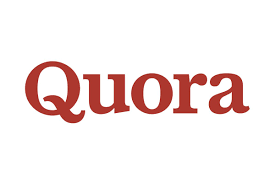

In [73]:
from IPython.display import Image
Image(filename='1.png')

# <h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

# Business Problem

## Description 

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


> Credits: Kaggle

__ Problem Statement __

Identify which questions asked on Quora are duplicates of questions that have already been asked.
This could be useful to instantly provide answers to questions that have already been answered.
We are tasked with predicting whether a pair of questions are duplicates or not.

### Sources/Useful Links 

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

### Real world/Business Objectives and Constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

# Machine Learning Probelm 

## Data  

### Data Overview  

- Data will be in a file Train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of Train.csv - 60MB 
- Number of rows in Train.csv = 404,290

### Example Data point 

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

# Mapping the real world problem to an ML problem 

## Type of Machine Leaning Problem  

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

### Performance Metric  

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

## Train and Test Construction

We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

# Exploratory Data Analysis 

In [2]:
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
import distance
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
import spacy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics.classification import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.linear_model import SGDClassifier
import warnings

In [3]:
#reading train file
data = pd.read_csv('train.csv')
data = data[:100000]
print("Data with total rows as {0} and column as {1}".format(data.shape[0], data.shape[1]))
print(data.columns, '\n\n')

Data with total rows as 100000 and column as 6
Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object') 




In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


In [5]:
#Checking whether there are any rows with null values
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [6]:
#removing decoding problems
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))

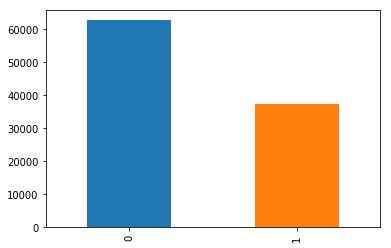


Total Data Points = 100000
Total data which is duplicate is 62.75
Total data which is not duplicate is 37.25


In [7]:
#data visulization of the class labels
data['is_duplicate'].value_counts().plot.bar()
plt.show()
print("\nTotal Data Points = {0}".format(data.shape[0]))
print("Total data which is duplicate is {0}".format( round((data['is_duplicate'].value_counts().to_dict()[0]/data.shape[0])*float(100), 2) ))
print("Total data which is not duplicate is {0}".format( round((data['is_duplicate'].value_counts().to_dict()[1]/data.shape[0])*float(100), 2) ))


Number of Unique questions are 165931

Questions asked more than once are 19446 (11.72%)

ONE Question which is asked maximum 32 number of times.

Duplicate entries in the Train data are 0



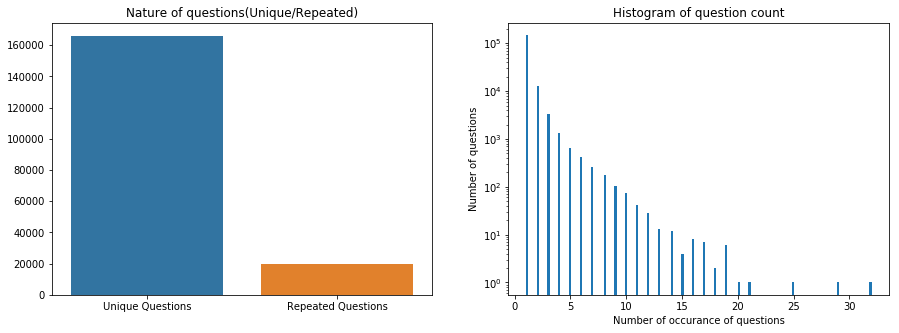

In [8]:
 #checking uniqueness of the questions
all_ques = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
uniq_ques = len(np.unique(all_ques))
multiple_times = np.sum(all_ques.value_counts() > 1)
print("Number of Unique questions are {0}".format(uniq_ques))
print("\nQuestions asked more than once are {0} ({1}%)".format(multiple_times, round((multiple_times/uniq_ques)*float(100), 2)))
print("\nONE Question which is asked maximum {0} number of times.".format(max(all_ques.value_counts())))
#checking duplicates
'''
directly by removing duplicate entries
'''
#shp2 = data.shape[0]
#data.drop_duplicates(subset={'qid1', 'qid2', 'is_duplicate'}, keep='first', inplace=True)
#shp1 = data.shape[0]
#print("\n{0} duplicate entries were present in data\n".format(shp2 - shp1))
'''
checking only if there is any duplicate entry present or not
'''
shp1 = data[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index().shape[0]
shp2 = data.shape[0]
print("\nDuplicate entries in the Train data are {0}\n".format(shp2 - shp1))
#plotting the required figures
plt.figure(figsize=(15, 5))
plt.subplot(121)
x = ['Unique Questions', 'Repeated Questions']

y = [uniq_ques, multiple_times]
sns.barplot(x, y)
plt.title('Nature of questions(Unique/Repeated)')
plt.subplot(122)
y1 = pd.Series(all_ques.value_counts()).tolist()
#x = range(len(y))
plt.hist(y1, bins=160)
plt.yscale('log')
plt.xlabel('Number of occurance of questions')
plt.ylabel('Number of questions')
plt.title('Histogram of question count')
plt.show()

# Basic Feature Extraction

In [9]:
#freq of words in each qids
data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count')
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
#len of questions in q1 and q2
data['len_que1'] = data['question1'].str.len()
data['len_que2'] = data['question2'].str.len()
#words in each of questions q1 and q2
data['q1_words'] = data['question1'].apply(lambda row:len(row.split(' ')))
data['q2_words'] = data['question2'].apply(lambda row:len(row.split(' ')))
#total common words in q1 and q2
def get_word_common(row):
    w1 = set(map(lambda word:word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word:word.lower().strip(), row['question2'].split(' ')))
    return 1.0 * len(w1 & w2)
data['word_common'] = data.apply(get_word_common, axis=1)
#length of total words in q1 and q2
def get_word_total(row):
    w1 = set(map(lambda word:word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word:word.lower().strip(), row['question2'].split(' ')))
    return 1.0 * (len(w1) + len(w2))
data['word_total'] = data.apply(get_word_total, axis=1)
#total percent of words shared between q1 and q2 considering total word length
def get_word_share(row):
    w1 = set(map(lambda word:word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word:word.lower().strip(), row['question2'].split(' ')))
    return 1.0 * (len(w1 & w2)/(len(w1)+len(w2)))
data['word_share'] = data.apply(get_word_share, axis=1)
#total freq of words in q1 and q2 and also absolute diff of length of words in q1 and q2
data['freq_q1_add_q2'] = data['freq_qid1'] + data['freq_qid2']
data['freq_q1_sub_q2'] = abs(data['freq_qid1'] - data['freq_qid2'])
data.columns


Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'len_que1', 'len_que2', 'q1_words',
       'q2_words', 'word_common', 'word_total', 'word_share', 'freq_q1_add_q2',
       'freq_q1_sub_q2'],
      dtype='object')

In [10]:
data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,len_que1,len_que2,q1_words,q2_words,word_common,word_total,word_share,freq_q1_add_q2,freq_q1_sub_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0


In [12]:
print("Minimum length of question in question_1 is {0}".format(min(data['q1_words'])))
print("Minimum length of question in question_2 is {0}".format(min(data['q2_words'])))
#number of questions with minimum length
print("Number of questions with minimum length (in question 1) {0}".format(data[data['q1_words']==1].shape[0]))
print("Number of questions with minimum length (in question 2) {0}".format(data[data['q2_words']==1].shape[0]))

Minimum length of question in question_1 is 1
Minimum length of question in question_2 is 1
Number of questions with minimum length (in question 1) 15
Number of questions with minimum length (in question 2) 5


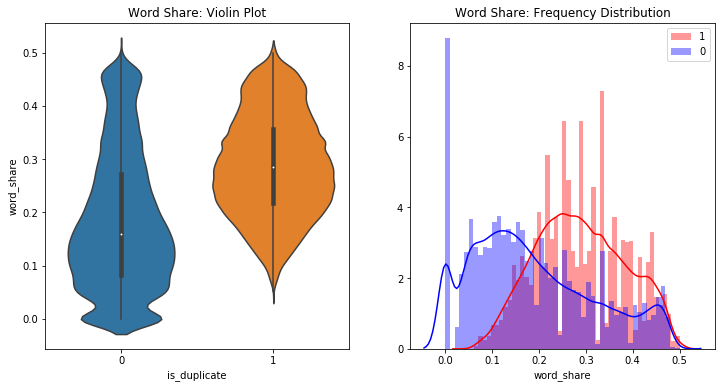

In [13]:
#word share
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Word Share: Violin Plot')
sns.violinplot(x='is_duplicate', y='word_share', data=data)
plt.subplot(122)
plt.title('Word Share: Frequency Distribution')
sns.distplot(data[data['is_duplicate']==1]['word_share'], label='1', color='red')
sns.distplot(data[data['is_duplicate']==0]['word_share'], label='0', color='blue')
plt.legend()
plt.show()

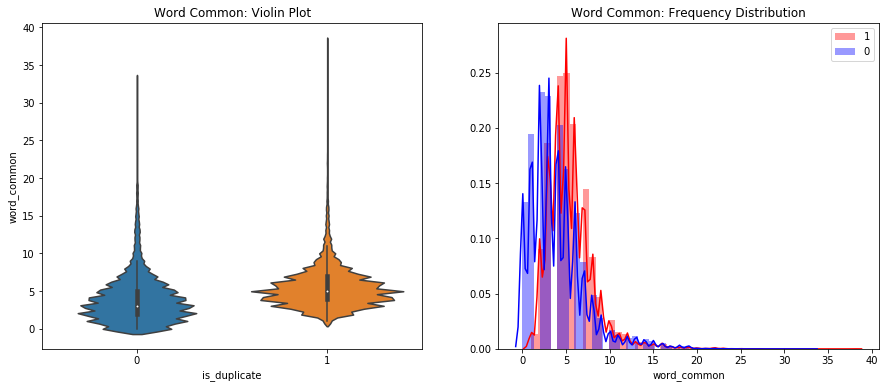

In [14]:
#word common
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.title('Word Common: Violin Plot')
sns.violinplot(x='is_duplicate', y='word_common', data=data)
plt.subplot(122)
plt.title('Word Common: Frequency Distribution')
sns.distplot(data[data['is_duplicate']==1]['word_common'], label='1', color='red')
sns.distplot(data[data['is_duplicate']==0]['word_common'], label='0', color='blue')
plt.legend()
plt.show()

## Processing of text 

In [15]:
stopwords = stopwords.words('english')
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′","'").replace("’", "'").replace("won't", "will not").\
    replace("cannot", "can not").replace("can't", "can not").replace("n't", " not").replace("what's", "what is").\
    replace("it's", "it is").replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
    .replace("he's", "he is").replace("she's","she is").replace("'s", " own")\
    .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
    .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    snow = SnowballStemmer('english')
    pattern = re.compile('\W')
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    if type(x) == type(''):
        x = snow.stem(x)
    #example1 = BeautifulSoup(x)
    #x = example1.get_text()
    return x

## Advance Feature Extraction 

In [16]:
def get_token_features(q1, q2):
    token_features = [0.0] * 10
    safe_div = 0.0001
    q1_tokens = q1.split() #total tokens in q1
    q2_tokens = q2.split() #total tokens in q2
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    else:
        q1_words = set([ words for words in q1_tokens if words not in stopwords ]) #total words in q1
        q2_words = set([ words for words in q2_tokens if words not in stopwords ]) #total words in q2

        q1_stop = set([ words for words in q1_tokens if words in stopwords ]) #total stopwords in q1
        q2_stop = set([ words for words in q2_tokens if words in stopwords ]) #total stopwords in q2

        cwc = len(q1_words.intersection(q2_words))
        csc = len(q1_stop.intersection(q2_stop))
        ctc = len(set(q1_tokens).intersection(set(q2_tokens)))

        token_features[0] = cwc / (min(len(q1_words), len(q2_words)) +safe_div) #cwc_min
        token_features[1] = cwc / (max(len(q1_words), len(q2_words)) +safe_div) #cwc_max
        token_features[2] = csc / (min(len(q1_stop), len(q2_stop)) + safe_div) #csc_min
        token_features[3] = csc / (max(len(q1_stop), len(q2_stop)) + safe_div) #csc_max
        token_features[4] = ctc / (min(len(q1_tokens), len(q2_tokens)) + safe_div) #ctc_min
        token_features[5] = ctc / (max(len(q1_tokens), len(q2_tokens)) + safe_div) #ctc_max

        token_features[6] = int(q1_tokens[-1]==q2_tokens[-1]) #last word same
        token_features[7] = int(q1_tokens[0]==q2_tokens[0]) #first word same
        token_features[8] = abs( len(q1_tokens) - len(q2_tokens) ) #absolute length difference
        token_features[9] = (len(q1_tokens) + len(q2_tokens))/2 #average length
        return token_features
#length of longest substring
def get_longest_common_substr(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [17]:
 #function to get advance features
def get_advance_features(df):
    df['question1'] = df['question1'].fillna('').apply(preprocess)
    df['question2'] = df['question2'].fillna('').apply(preprocess)
    print('Processing token features ... ')

    token_features = df.apply(lambda x: get_token_features(x['question1'], x['question2']), axis=1 )

    df['cwc_min'] = list(map(lambda x:x[0], token_features))
    df['cwc_max'] = list(map(lambda x:x[1], token_features))
    df['csc_min'] = list(map(lambda x:x[2], token_features))
    df['csc_max'] = list(map(lambda x:x[3], token_features))
    df['ctc_min'] = list(map(lambda x:x[4], token_features))
    df['ctc_max'] = list(map(lambda x:x[5], token_features))
    df['last_word_same'] = list(map(lambda x:x[6], token_features))
    df['first_word_same'] = list(map(lambda x:x[7], token_features))
    df['abs_len_diff'] = list(map(lambda x:x[8], token_features))
    df['mean_len'] = list(map(lambda x:x[9], token_features))

    print('Processing fuzzy features ... ')

    df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
    df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)

    df['longest_substr_ratio'] = df.apply(lambda x: get_longest_common_substr(x['question1'], x['question2']), axis=1)
    return df

In [18]:
data = get_advance_features(data)

Processing token features ... 
Processing fuzzy features ... 


In [19]:
print(data.columns)
print("Number of features of transformed data after feature extraction is : {0}".format(data.shape[1]))

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'len_que1', 'len_que2', 'q1_words',
       'q2_words', 'word_common', 'word_total', 'word_share', 'freq_q1_add_q2',
       'freq_q1_sub_q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_same', 'first_word_same', 'abs_len_diff',
       'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio',
       'token_sort_ratio', 'longest_substr_ratio'],
      dtype='object')
Number of features of transformed data after feature extraction is : 32


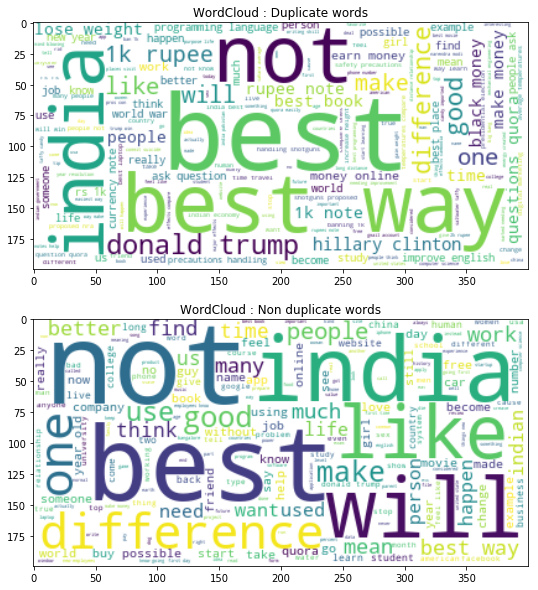

In [20]:
duplicate_data = data[data['is_duplicate'] == 1]
non_duplicate_data = data[data['is_duplicate'] == 0]
#combining the text of both questions from duplicate and non-duplicate data
duplicate_ques = ' '.join(np.dstack([duplicate_data['question1'],duplicate_data['question2']]).flatten())
non_duplicate_ques = ' '.join(np.dstack([non_duplicate_data['question1'], non_duplicate_data['question2']]).flatten())

#customizing the stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
stopwords.remove("like")
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.title('WordCloud : Duplicate words')
wc_dup = WordCloud(background_color="white", stopwords=stopwords)
wc_dup.generate(duplicate_ques)
plt.imshow(wc_dup, interpolation='bilinear')
plt.subplot(212)
plt.title('WordCloud : Non duplicate words')
wc_n_dup = WordCloud(background_color="white", stopwords=stopwords)
wc_n_dup.generate(non_duplicate_ques)
plt.imshow(wc_n_dup, interpolation='bilinear')
plt.show()

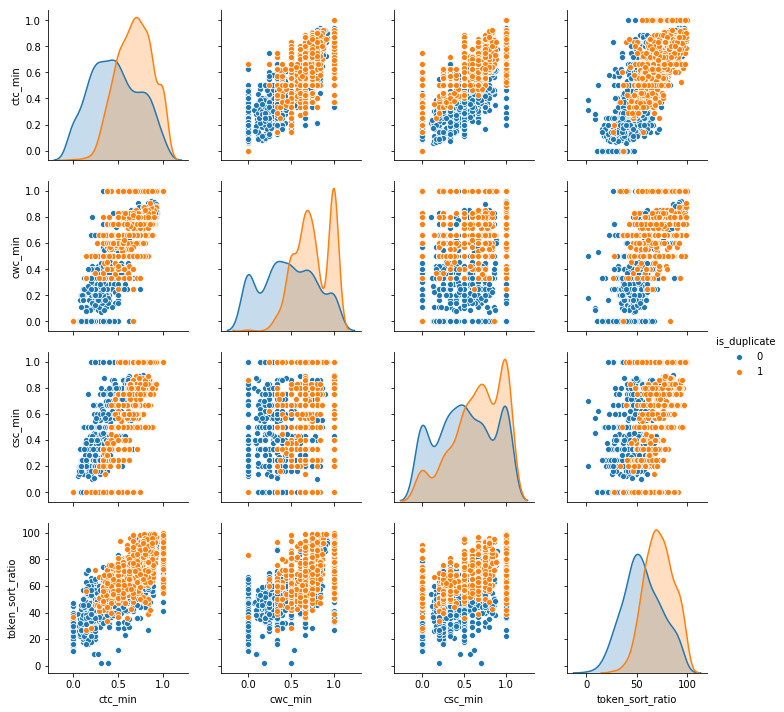

In [21]:
## Pair plot of features : cwc_min, csc_min, ctc_min, token_sort_ratio, is_duplicate
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][:2000],\
             hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

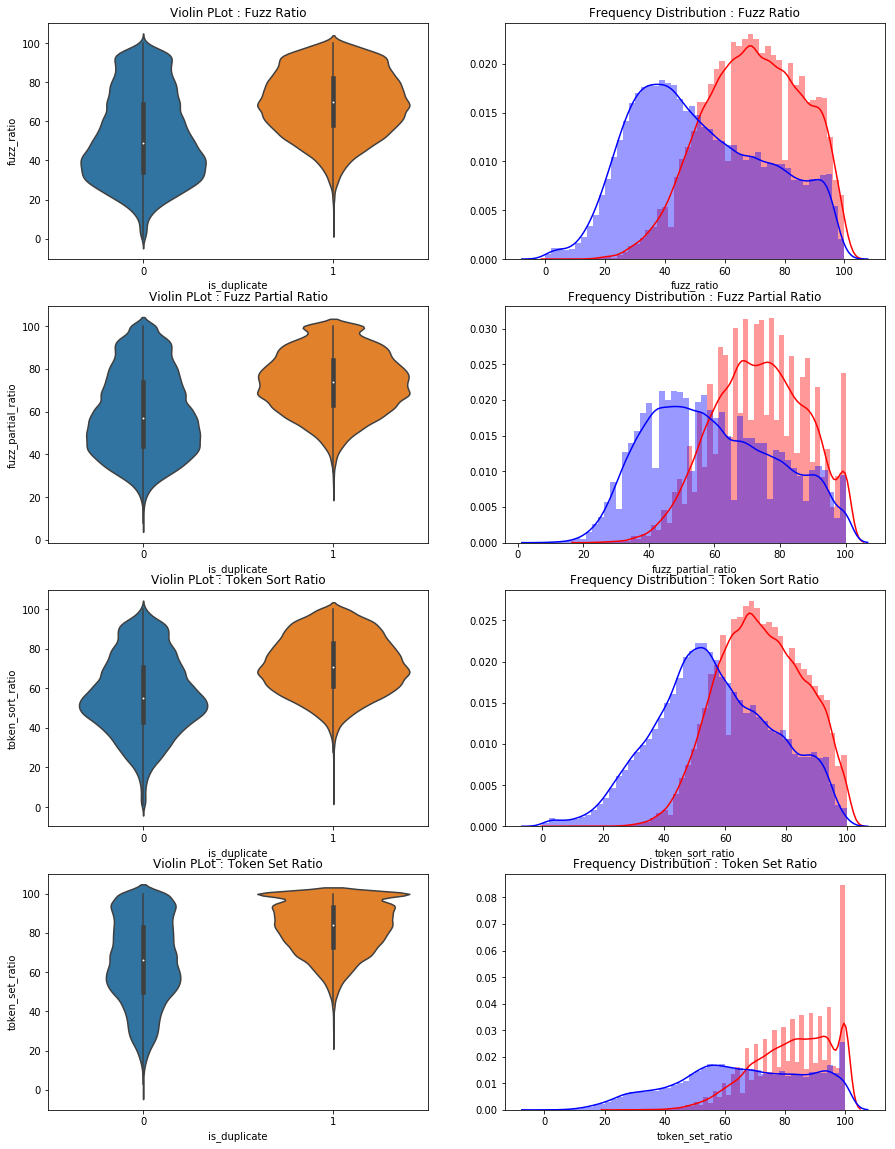

In [22]:
plt.figure(figsize=(15, 20))
#distribution of fuzz_ratio
plt.subplot(421)
sns.violinplot(x='is_duplicate', y='fuzz_ratio', data=data)
plt.title('Violin PLot : Fuzz Ratio')
plt.subplot(422)
sns.distplot(data[data['is_duplicate']==1]['fuzz_ratio'], label='1', color='red')
sns.distplot(data[data['is_duplicate']==0]['fuzz_ratio'], label='0', color='blue')
plt.title('Frequency Distribution : Fuzz Ratio')
#fuzz_partial_ratio
plt.subplot(423)
sns.violinplot(x='is_duplicate', y='fuzz_partial_ratio', data=data)
plt.title('Violin PLot : Fuzz Partial Ratio')
plt.subplot(424)
sns.distplot(data[data['is_duplicate']==1]['fuzz_partial_ratio'], label='1', color='red')
sns.distplot(data[data['is_duplicate']==0]['fuzz_partial_ratio'], label='0', color='blue')
plt.title('Frequency Distribution : Fuzz Partial Ratio')
#token sort ratio
plt.subplot(425)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=data)
plt.title('Violin PLot : Token Sort Ratio')
plt.subplot(426)
sns.distplot(data[data['is_duplicate']==1]['token_sort_ratio'], label='1', color='red')
sns.distplot(data[data['is_duplicate']==0]['token_sort_ratio'], label='0', color='blue')
plt.title('Frequency Distribution : Token Sort Ratio')
#token set ratio

plt.subplot(427)
sns.violinplot(x='is_duplicate', y='token_set_ratio', data=data)
plt.title('Violin PLot : Token Set Ratio')
plt.subplot(428)
sns.distplot(data[data['is_duplicate']==1]['token_set_ratio'], label= '1', color='red')
sns.distplot(data[data['is_duplicate']==0]['token_set_ratio'], label='0', color='blue')
plt.title('Frequency Distribution : Token Set Ratio')
plt.show()

From above plots we can say that, features Fuzz Ration and Token Sort Ratio can deliver considerable amount of data from their plots and also the plots are quiet distinct compared to other two features and hence we can say that these two can be useful in our modeling.

## Visulization using T-SNE (Advance Features) 

In [23]:
X = data[['ctc_min', 'ctc_max', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'last_word_same', 'first_word_same', \
 'abs_len_diff', 'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio','token_sort_ratio', 'longest_substr_ratio']]
print(X.columns)
print(X.shape)
Y = data['is_duplicate']

Index(['ctc_min', 'ctc_max', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'last_word_same', 'first_word_same', 'abs_len_diff', 'mean_len',
       'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio',
       'token_sort_ratio', 'longest_substr_ratio'],
      dtype='object')
(100000, 15)


In [24]:
tsne_adv_features = TSNE(n_components=2, init='random', method='barnes_hut', perplexity=30,n_iter=1000, learning_rate=200,\
                         random_state=100, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.783s...
[t-SNE] Computed neighbors for 100000 samples in 61.582s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional probab

[t-SNE] Iteration 550: error = 4.0984635, gradient norm = 0.0002314 (50 iterations in 383.112s)
[t-SNE] Iteration 600: error = 3.9596000, gradient norm = 0.0001999 (50 iterations in 382.610s)
[t-SNE] Iteration 650: error = 3.8390334, gradient norm = 0.0001756 (50 iterations in 387.630s)
[t-SNE] Iteration 700: error = 3.7344887, gradient norm = 0.0001552 (50 iterations in 385.128s)
[t-SNE] Iteration 750: error = 3.6431670, gradient norm = 0.0001373 (50 iterations in 381.279s)
[t-SNE] Iteration 800: error = 3.5624292, gradient norm = 0.0001229 (50 iterations in 381.683s)
[t-SNE] Iteration 850: error = 3.4902110, gradient norm = 0.0001113 (50 iterations in 382.015s)
[t-SNE] Iteration 900: error = 3.4254386, gradient norm = 0.0001012 (50 iterations in 251.368s)
[t-SNE] Iteration 950: error = 3.3670688, gradient norm = 0.0000925 (50 iterations in 242.528s)
[t-SNE] Iteration 1000: error = 3.3137398, gradient norm = 0.0000851 (50 iterations in 241.993s)
[t-SNE] Error after 1000 iterations: 3.

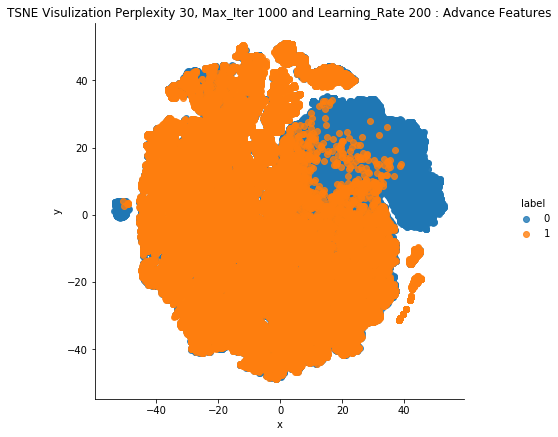

In [25]:
tsne_df = pd.DataFrame({'x':tsne_adv_features[:,0], 'y':tsne_adv_features[:,1], 'label':Y})
sns.lmplot(data=tsne_df, x='x', y='y', hue='label', height=6, fit_reg=False)
plt.title('TSNE Visulization Perplexity {0}, Max_Iter {1} and Learning_Rate {2} : Advance Features'.format(30, 1000, 200))
plt.show()

## TF-IDF Vectorizer of the questions 

In [26]:
data1 = pd.read_csv('train.csv')
data1 = data1[:100000]
labels = data1['is_duplicate']
data1 = data1.fillna(' ')

In [27]:
data1.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [28]:
labels.head(2)

0    0
1    0
Name: is_duplicate, dtype: int64

In [29]:
#splitting data into (70:30)
xTrain, xTest, yTrain, yTest = train_test_split(data1, labels, stratify=labels, test_size=0.3)
print("Number of data points in Train data {0}.".format(xTrain.shape[0]))
print("Number of data points in Test data {0}.".format(xTest.shape[0]))

Number of data points in Train data 70000.
Number of data points in Test data 30000.


In [30]:
train_y = Counter(yTrain)
train_len = len(yTrain)
test_y = Counter(yTest)
test_len = len(yTest)
print("Train contains {0}% of Class 0 points and {1}% of Class 1 points.".\
      format(round((train_y[0]/train_len)*float(100), 2), round((train_y[1]/train_len)*float(100), 2)))
print("Test contains {0}% of Class 0 points and {1}% of Class 1 points.".\
      format(round((test_y[0]/test_len)*float(100), 2), round((test_y[1]/test_len)*float(100), 2)))

Train contains 62.75% of Class 0 points and 37.25% of Class 1 points.
Test contains 62.75% of Class 0 points and 37.25% of Class 1 points.


In [31]:
xTrain.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
49106,49106,43595,18366,"Is vacuum energy infinite? If it is, how and w...",Is at least the potential energy of vacuum ene...,1
33018,33018,12717,1886,What are the various ways through which one ca...,How can I earn money on internet?,1


In [32]:
all_questions_train = list(xTrain['question1']) + list(xTrain['question2'])
tfidf = TfidfVectorizer(lowercase=False, max_features=5000)
tfidf.fit_transform(all_questions_train, yTrain)
xTrain_tfidf = tfidf.transform(xTrain)
xTest_tfidf = tfidf.transform(xTest)
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [33]:
#loading vectors representation of English words from spacy
nlp = spacy.load('en_core_web_sm')

In [34]:
ques_one_vect = list()
for line in tqdm(list(data1['question1'])):
    doc = nlp(line)
    mean_vect = np.zeros([len(doc), len(doc[0].vector)])
    for word in doc:
        vect = word.vector
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        mean_vect += vect * idf
    mean_vect = mean_vect.mean(axis=0)
    ques_one_vect.append(mean_vect)
data1['question1_vect'] = ques_one_vect

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [19:55<00:00, 83.68it/s]


In [35]:
ques_two_vect = list()
for line in tqdm(list(data1['question2'])):
    doc = nlp(line)
    mean_vect = np.zeros([len(doc), len(doc[0].vector)])
    for word in doc:
        vect = word.vector
        try:
            idf = word2tfidf[str(word)]
        except:
            idf = 0
        mean_vect += vect * idf
    mean_vect = mean_vect.mean(axis=0)
    ques_two_vect.append(mean_vect)
data1['question2_vect'] = ques_two_vect

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [19:56<00:00, 83.55it/s]


In [36]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'len_que1', 'len_que2', 'q1_words',
       'q2_words', 'word_common', 'word_total', 'word_share', 'freq_q1_add_q2',
       'freq_q1_sub_q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_same', 'first_word_same', 'abs_len_diff',
       'mean_len', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_set_ratio',
       'token_sort_ratio', 'longest_substr_ratio'],
      dtype='object')

In [37]:
data1.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'question1_vect', 'question2_vect'],
      dtype='object')

In [38]:
df_1 = pd.DataFrame(data1.question1_vect.values.tolist(), index=data1.index)
df_2 = pd.DataFrame(data1.question2_vect.values.tolist(), index=data1.index)
df_1['id'] = data1['id']
df_2['id'] = data1['id']
df = data1.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)

In [39]:
df.head(2)

,id,question1_vect,question2_vect
0,0,"[210.8547761440277, -144.59517323970795, -68.4...","[151.86991095542908, -127.13523137569427, -31...."
1,1,"[9.905271053314209, -47.35130999982357, -22.40...","[66.02289712429047, -32.8748596906662, -72.060..."


In [40]:
#merging all dataframes
data = data.merge(df_1, on='id', how='left')
data = data.merge(df_2, on='id', how='left')
print(data.columns)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'len_que1', 'len_que2',
       ...
       '86_y', '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
       '95_y'],
      dtype='object', length=224)


In [41]:
data.shape

(100000, 224)

# Machine Learning Models

In [42]:
mod_data = data.sample(n=100000, random_state=25) #taking random sample of data
mod_data.drop(mod_data.index[0], inplace=True) #removing index column
labels = mod_data['is_duplicate']
mod_data.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'],axis=1, inplace=True) #removing columns containing raw data
train_data, test_data, train_labels, test_labels = train_test_split(mod_data, labels,stratify=labels, test_size=0.3)

In [43]:
print(mod_data.shape)
print(mod_data.columns)

(99999, 219)
Index(['id', 'freq_qid1', 'freq_qid2', 'len_que1', 'len_que2', 'q1_words',
       'q2_words', 'word_common', 'word_total', 'word_share',
       ...
       '86_y', '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y',
       '95_y'],
      dtype='object', length=219)


In [44]:
#converting all columns into numeric
for col in list(mod_data.columns):
    mod_data[col] = mod_data.apply(pd.to_numeric)
labels = list(map(int, labels.values))

In [45]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))

    labels = [1,2]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

## Building a Random Model 

Log loss on Test Data using Random Model 0.8909385095902461


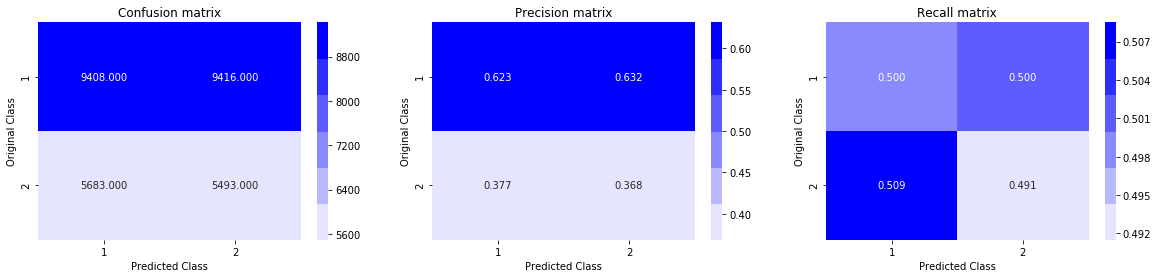

In [46]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log loss on Test Data using Random Model",log_loss(yTest, predicted_y, eps=1e-15))
    
predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(yTest, predicted_y)

## Logistic Regression with Hyper-Parameter tuning 

In [47]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
train_data = scale.fit_transform(train_data)
test_data = scale.transform(test_data)

In [51]:
from sklearn.linear_model import SGDClassifier

For values of alpha =  1e-05 The log loss is: 0.5124491123853023
For values of alpha =  0.0001 The log loss is: 0.5092806386885951
For values of alpha =  0.001 The log loss is: 0.4532054378091312
For values of alpha =  0.01 The log loss is: 0.4540448424304775
For values of alpha =  0.1 The log loss is: 0.4791728647142403
For values of alpha =  1 The log loss is: 0.515345888040421
For values of alpha =  10 The log loss is: 0.5556387407145182


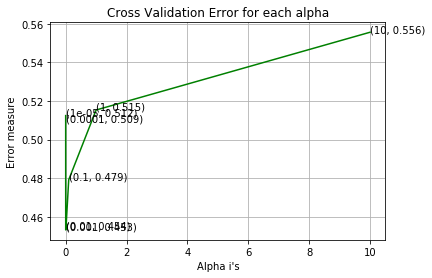

For values of best alpha =  0.001 The train log loss is: 0.44424638169916425
For values of best alpha =  0.001 The test log loss is: 0.4532054378091312
Total number of data points : 30000


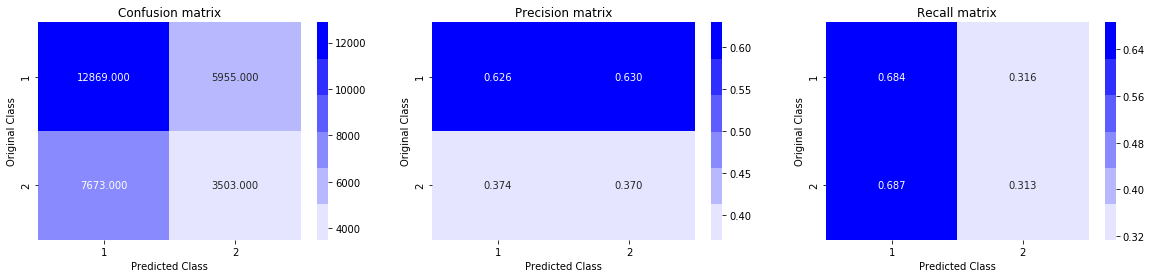

In [52]:
warnings.filterwarnings("ignore")
alpha = [10 ** x for x in range(-5, 2)]
log_error_array=list()
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log',class_weight= 'balanced', random_state=42)
    clf.fit(train_data, train_labels)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_data, train_labels)
    predict_y = sig_clf.predict_proba(test_data)
    log_error_array.append(log_loss(test_labels, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(test_labels, predict_y, labels=clf.classes_, eps=1e-15))
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log',class_weight= 'balanced', random_state=42)
clf.fit(train_data, train_labels)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_data, train_labels)
predict_y = sig_clf.predict_proba(train_data)

print('For values of best alpha = ', alpha[best_alpha],"The train log loss is:",log_loss(train_labels,\
                                                                                         predict_y, labels=clf.classes_,\
                                                                                         eps=1e-15))
predict_y = sig_clf.predict_proba(test_data)
print('For values of best alpha = ', alpha[best_alpha], \
      "The test log loss is:",log_loss(test_labels, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(yTest, predicted_y)

## Linear SVM with Hyper-parameter tuning 

For values of alpha =  1e-05 The log loss is: 0.6931471805599453
For values of alpha =  0.0001 The log loss is: 0.6931471805599453
For values of alpha =  0.001 The log loss is: 0.6931471805599453
For values of alpha =  0.01 The log loss is: 0.6931471805599453
For values of alpha =  0.1 The log loss is: 0.6931471805599453
For values of alpha =  1 The log loss is: 0.6931471805599453
For values of alpha =  10 The log loss is: 0.6931471805599453


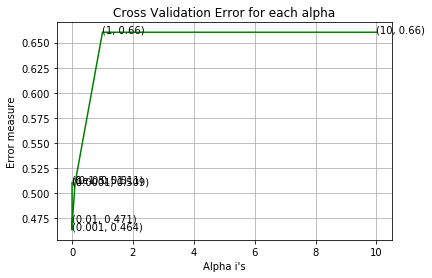

For values of best alpha =  0.001 The train log loss is: 0.4579200914657504
For values of best alpha =  0.001 The test log loss is: 0.46350965975192
Total number of data points : 30000


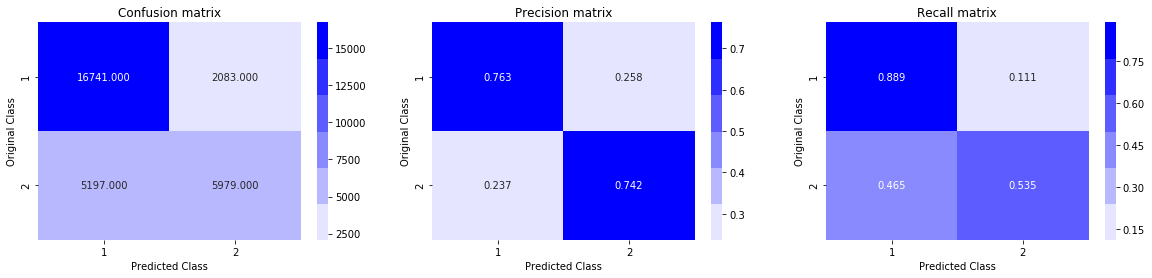

In [53]:
warnings.filterwarnings("ignore")
alpha = [10 ** x for x in range(-5, 2)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', class_weight= 'balanced', random_state=42)
    clf.fit(train_data, train_labels)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_data, train_labels)
    predict_y = sig_clf.predict_proba(test_data)
    log_error_array.append(log_loss(test_labels, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:", \
          log_loss(test_labels, predict_y, labels=clf.classes_, eps=1e15))
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge',class_weight = 'balanced', random_state=42)
clf.fit(train_data, train_labels)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_data, train_labels)
predict_y = sig_clf.predict_proba(train_data)

print('For values of best alpha = ', alpha[best_alpha], \
      "The train log loss is:",log_loss(train_labels, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_data)
print('For values of best alpha = ', alpha[best_alpha], \
      "The test log loss is:",log_loss(test_labels, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_labels, predicted_y)

## XGBOOST 

In [54]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

## Hyper parameter tuning of XGBoost 

In [57]:
n_estimators = [100, 300, 500, 700, 900, 1100, 1300, 1500]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
colsample_bytree = [0.1, 0.3, 0.5, 0.7 , 0.9, 1]
subsample = [0.1,0.3,0.5,0.7,0.9,1]

def hyperparameter_tunning(X,Y):
    param_grid = dict(learning_rate=learning_rate,
                      n_estimators=n_estimators,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample)
    
    model = XGBClassifier(nthread=-1)
    kfold = StratifiedKFold(n_splits=3, shuffle=True)
    random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    random_result = random_search.fit(X,Y)
    
    # Summarize results
    print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
    print()
    means = random_result.cv_results_['mean_test_score']
    stds = random_result.cv_results_['std_test_score']
    params = random_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return random_result

In [58]:
import datetime as dt
start = dt.datetime.now()

# Tune hyperparameter values
random_result = hyperparameter_tunning(train_data,train_labels)

print("\nTimeTaken: ",dt.datetime.now() - start)

Best: -0.376256 using {'subsample': 0.7, 'colsample_bytree': 0.1, 'learning_rate': 0.1, 'n_estimators': 700}

-0.522991 (0.000827) with: {'subsample': 0.9, 'colsample_bytree': 1, 'learning_rate': 0.001, 'n_estimators': 900}
-0.376256 (0.001828) with: {'subsample': 0.7, 'colsample_bytree': 0.1, 'learning_rate': 0.1, 'n_estimators': 700}
-0.444131 (0.001898) with: {'subsample': 0.5, 'colsample_bytree': 1, 'learning_rate': 0.3, 'n_estimators': 1300}
-0.382301 (0.002193) with: {'subsample': 1, 'colsample_bytree': 0.9, 'learning_rate': 0.2, 'n_estimators': 100}
-0.423814 (0.001998) with: {'subsample': 0.3, 'colsample_bytree': 1, 'learning_rate': 0.2, 'n_estimators': 1100}
-0.670268 (0.000124) with: {'subsample': 0.3, 'colsample_bytree': 0.9, 'learning_rate': 0.0001, 'n_estimators': 700}
-0.689856 (0.000011) with: {'subsample': 0.3, 'colsample_bytree': 0.5, 'learning_rate': 0.0001, 'n_estimators': 100}
-0.376754 (0.002092) with: {'subsample': 0.9, 'colsample_bytree': 0.1, 'learning_rate': 0.

In [59]:
xGBClassifier = XGBClassifier(max_depth=3, 
                              learning_rate=0.1, 
                              n_estimators=700,
                              subsample=0.7,
                              colsample_bytree= 0.1, 
                              nthread=-1)
xGBClassifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=700, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1)

In [60]:
import xgboost as xgb

start = dt.datetime.now()
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 3
params['colsample_bytree'] = 0.1
params['n_estimators'] = 700
params['subsample'] = 0.7
params['learning_rate'] = 0.1
params['nthread'] = -1
params['silent'] = 1

d_train = xgb.DMatrix(train_data, label=train_labels)
d_test = xgb.DMatrix(test_data, label=test_labels)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist,verbose_eval= False,early_stopping_rounds=20)

xgdmat = xgb.DMatrix(train_data,train_labels)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(test_labels, predict_y, labels=clf.classes_, eps=1e-15))
print("\nTime Taken: ",dt.datetime.now() - start)

The test log loss is: 0.3844531519655506

Time Taken:  0:01:27.752145


Total number of data points : 30000


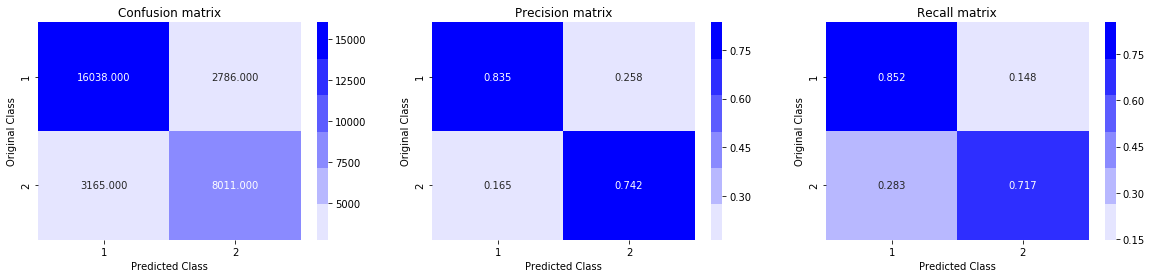

In [61]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(test_labels, predicted_y)

XGBOOST showing good precision and recall comapre to logistic regression and linear svm

# Conclusion

In [62]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ['Dataset Size', 'Model Name', 'Tokenizer', 'Test Log Loss']

ptable.add_row([" 100K","Logistic Regression","TFIDF","0.4532"])
ptable.add_row([" 100K","Linear SVM","TFIDF","0.4635"])
ptable.add_row([" 100K","XGBoost","TFIDF ","0.3844"])

print(ptable)

+--------------+---------------------+-----------+---------------+
| Dataset Size |      Model Name     | Tokenizer | Test Log Loss |
+--------------+---------------------+-----------+---------------+
|     100K     | Logistic Regression |   TFIDF   |     0.4532    |
|     100K     |      Linear SVM     |   TFIDF   |     0.4635    |
|     100K     |       XGBoost       |   TFIDF   |     0.3844    |
+--------------+---------------------+-----------+---------------+
